In [ ]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pandas as pd
import torch
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [36]:
# first steps are like task 1, we need to create pandas df

# create dataset using sklearn
# 0 is business, 1 is entertainment, 2 is politics, 3 is sport, 4 is tech
labels=["business","entertainment","politics","sport","tech"]
bbc_data = load_files(r"/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/Module_6_NLP/Homework/bbc", encoding="utf-8", decode_error = 'replace' )
X, y = bbc_data.data, bbc_data.target

In [37]:
#convert dataset to pandas df
NUM_LABELS= len(labels)
id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

df = pd.DataFrame(data = X, columns = ['text'])
df['target'] = y
df["category"]=df.target.map(lambda x: id2label[x])
df.head()

,text,target,category
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0,business
1,Halo 2 sells five million copies\n\nMicrosoft ...,4,tech
2,MSPs hear renewed climate warning\n\nClimate c...,2,politics
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3,sport
4,Tories reject rethink on axed MP\n\nSacked MP ...,2,politics


In [38]:
#use regex to clean the text
# text preprocessing, remove all the special characters using regex
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
stemmer = Mystem()
def regex_preprocessing(X):
    documents = []

    for sen in range(len(X)):
        # Remove all the special characters, only letters are left
        document = str(X[sen])
        document = document.rstrip()
        document = re.sub(r'\W', ' ', document)

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        # Lemmatization
        #document = document.split()
        document = "".join(stemmer.lemmatize(document)).strip()


        documents.append(document)

    return documents

In [39]:
df['preprocessed_text'] = regex_preprocessing(X)
df.head()

,text,target,category,preprocessed_text
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0,business,tate lyle boss bags top award tate lyle chief ...
1,Halo 2 sells five million copies\n\nMicrosoft ...,4,tech,halo 2 sells five million copies microsoft is ...
2,MSPs hear renewed climate warning\n\nClimate c...,2,politics,msps hear renewed climate warning climate chan...
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3,sport,pavey focuses on indoor success jo pavey will ...
4,Tories reject rethink on axed MP\n\nSacked MP ...,2,politics,tories reject rethink on axed mp sacked mp how...


In [40]:
#break the dataframe according to topic's categories
df_business = df[df['category'] == 'business']
df_sport = df[df['category'] == 'sport']
df_politics = df[df['category'] == 'politics']
df_tech = df[df['category'] == 'tech']
df_ent = df[df['category'] == "entertainment"]



In [41]:
df_ent.head()

,text,target,category,preprocessed_text
11,Public show for Reynolds portrait\n\nSir Joshu...,1,entertainment,public show for reynolds portrait sir joshua r...
20,Elvis set to top UK singles chart\n\nRock 'n' ...,1,entertainment,elvis set to top uk singles chart rock roll le...
26,Prodigy join V Festival line-up\n\nEssex act P...,1,entertainment,prodigy join festival line up essex act prodig...
36,Brits return Keane to number one\n\nBrits succ...,1,entertainment,brits return keane to number one brits success...
42,Rapper 50 Cent scores chart first\n\nRapper 50...,1,entertainment,rapper 50 cent scores chart first rapper 50 ce...


In [42]:
df_ent['text'].iloc[0]

'Public show for Reynolds portrait\n\nSir Joshua Reynolds\' Portrait of Omai will get a public airing following fears it would stay hidden because of an export wrangle.\n\nThe Tate Gallery unsuccessfully tried to buy the picture from its anonymous owner after a ban was issued preventing the painting from leaving the UK. The 18th Century painting has remained in storage but the owner has agreed to allow it to be part of an exhibition. The exhibition of Reynolds\' work will be shown at Tate Britain from May. Joshua Reynolds: The Creation of Celebrity will feature prints, caricatures, and sculpture by the 18th Century artist, who painted some of the most famous personalities of his day. Portrait of Omai fetched the second highest amount for a British painting when it was sold at auction for £10.3m in 2001. It was bought by a London dealer who sold it on to a collector. The unnamed collector wanted to take it out of the country, but was barred from doing so by the government because of its

In [43]:
df_ent['preprocessed_text'].iloc[0]

'public show for reynolds portrait sir joshua reynolds portrait of omai will get public airing following fears it would stay hidden because of an export wrangle the tate gallery unsuccessfully tried to buy the picture from its anonymous owner after ban was issued preventing the painting from leaving the uk the 18th century painting has remained in storage but the owner has agreed to allow it to be part of an exhibition the exhibition of reynolds work will be shown at tate britain from may joshua reynolds the creation of celebrity will feature prints caricatures and sculpture by the 18th century artist who painted some of the most famous personalities of his day portrait of omai fetched the second highest amount for british painting when it was sold at auction for 10 3m in 2001 it was bought by london dealer who sold it on to collector the unnamed collector wanted to take it out of the country but was barred from doing so by the government because of its historical significance in march

Analysis for business column

In [44]:
# LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['said', 'will', 'us']

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = df_business.preprocessed_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])
# we need it later for word cloud
resultList = [element for nestedlist in data_words for element in nestedlist]
resultList

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marharyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['tate', 'lyle', 'boss', 'bags', 'top', 'award', 'tate', 'lyle', 'chief', 'executive', 'named', 'european', 'businessman', 'year', 'leading', 'business', 'magazine', 'iain', 'ferguson', 'awarded', 'title', 'publication', 'forbes', 'returning', 'one', 'uk', 'venerable', 'manufacturers', 'country', 'top']


['tate',
 'lyle',
 'boss',
 'bags',
 'top',
 'award',
 'tate',
 'lyle',
 'chief',
 'executive',
 'named',
 'european',
 'businessman',
 'year',
 'leading',
 'business',
 'magazine',
 'iain',
 'ferguson',
 'awarded',
 'title',
 'publication',
 'forbes',
 'returning',
 'one',
 'uk',
 'venerable',
 'manufacturers',
 'country',
 'top',
 'companies',
 'sugar',
 'group',
 'absent',
 'ftse',
 'seven',
 'years',
 'mr',
 'ferguson',
 'helped',
 'return',
 'growth',
 'tate',
 'shares',
 'leapt',
 'year',
 'boosted',
 'firming',
 'sugar',
 'prices',
 'sales',
 'artificial',
 'sweeteners',
 'years',
 'sagging',
 'stock',
 'price',
 'seven',
 'year',
 'hiatus',
 'ftse',
 'one',
 'britain',
 'venerable',
 'manufacturers',
 'returned',
 'vaunted',
 'index',
 'forbes',
 'mr',
 'ferguson',
 'took',
 'helm',
 'company',
 'spending',
 'career',
 'consumer',
 'goods',
 'giant',
 'unilever',
 'tate',
 'lyle',
 'original',
 'member',
 'historic',
 'ft',
 'index',
 'operates',
 'factories',
 'additional',
 '

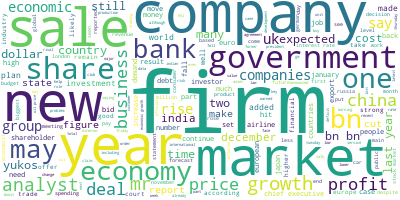

In [45]:
# exploratory data analysis using wordcloud for business

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(resultList)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [46]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 3), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1)]


In [47]:
# model training
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word, num_topics = num_topics,
                                       alpha='auto', eta='auto', iterations = 20, passes = 5)
# Print the Keyword in the 10 topics
print(lda.show_topics(5))

[(1, '0.008*"bn" + 0.005*"would" + 0.005*"year" + 0.005*"mr" + 0.004*"executive" + 0.004*"also" + 0.004*"new" + 0.004*"chief" + 0.004*"sales" + 0.004*"deal"'), (6, '0.012*"sales" + 0.009*"rates" + 0.009*"year" + 0.008*"bank" + 0.008*"growth" + 0.007*"economy" + 0.006*"interest" + 0.006*"market" + 0.006*"figures" + 0.006*"prices"'), (9, '0.009*"bn" + 0.008*"year" + 0.007*"would" + 0.006*"company" + 0.006*"deutsche" + 0.006*"also" + 0.006*"lse" + 0.005*"boerse" + 0.005*"last" + 0.005*"offer"'), (2, '0.010*"year" + 0.009*"growth" + 0.007*"dollar" + 0.007*"economy" + 0.006*"bn" + 0.005*"prices" + 0.005*"economic" + 0.005*"also" + 0.004*"rate" + 0.004*"market"'), (4, '0.011*"bn" + 0.007*"government" + 0.006*"year" + 0.005*"oil" + 0.005*"would" + 0.005*"yukos" + 0.004*"firm" + 0.004*"economy" + 0.004*"new" + 0.004*"economic"')]


In [48]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
vis_data

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.004221 -0.036208       1        1  19.633070
2      0.089072  0.013829       2        1  18.046370
9     -0.025128  0.023904       3        1  10.307529
7     -0.032226  0.006740       4        1   9.897098
8      0.013750 -0.028704       5        1   8.817524
0     -0.050195 -0.055470       6        1   8.001967
5     -0.039014 -0.056393       7        1   7.415164
3     -0.079244  0.106158       8        1   7.289011
6      0.134321  0.026476       9        1   6.828649
1     -0.015556 -0.000332      10        1   3.763617, topic_info=            Term        Freq       Total Category  logprob  loglift
50            mr  529.000000  529.000000  Default  30.0000  30.0000
1047       yukos  176.000000  176.000000  Default  29.0000  29.0000
3018       rates  141.000000  141.000000  Default  28.0000  28.0000
65         sales  287.000000  287.000000  Default  27.0000  27.0000
5718      glazer   55.000000   55.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
710   government    9.645807  305.437125  Topic10  -5.9252  -0.1754
15     companies    9.043471  189.172704  Topic10  -5.9897   0.2392
594      largest    8.433818   96.342630  Topic10  -6.0595   0.8441
16       company    8.698197  370.991977  Topic10  -6.0287  -0.4733
145         firm    8.591841  325.365320  Topic10  -6.0410  -0.3543

[765 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5839      2  0.880242        absa
776       1  0.025226  accounting
776       2  0.201808  accounting
776       3  0.050452  accounting
776       4  0.201808  accounting
...     ...       ...         ...
1047      7  0.362544       yukos
1047      8  0.005665       yukos
1047      9  0.022659       yukos
1047     10  0.005665       yukos
1826      2  0.914259  yushchenko

[2417 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 10, 8, 9, 1, 6, 4, 7, 2])

***Analysis for sport column***

In [49]:
# now the same for other topics
# LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['said', 'will', 'us']

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = df_sport.preprocessed_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])
# we need it later for word cloud
resultList = [element for nestedlist in data_words for element in nestedlist]
resultList

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marharyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['pavey', 'focuses', 'indoor', 'success', 'jo', 'pavey', 'miss', 'january', 'view', 'great', 'edinburgh', 'international', 'cross', 'country', 'focus', 'preparing', 'european', 'indoor', 'championships', 'march', 'year', 'old', 'third', 'behind', 'hayley', 'yelling', 'justyna', 'bak', 'last', 'week']


['pavey',
 'focuses',
 'indoor',
 'success',
 'jo',
 'pavey',
 'miss',
 'january',
 'view',
 'great',
 'edinburgh',
 'international',
 'cross',
 'country',
 'focus',
 'preparing',
 'european',
 'indoor',
 'championships',
 'march',
 'year',
 'old',
 'third',
 'behind',
 'hayley',
 'yelling',
 'justyna',
 'bak',
 'last',
 'week',
 'european',
 'cross',
 'country',
 'championships',
 'prefers',
 'race',
 'track',
 'great',
 'winning',
 'bronze',
 'wary',
 'injuries',
 'must',
 'concentrate',
 'indoor',
 'season',
 'previous',
 'injuries',
 'even',
 'run',
 'hills',
 'training',
 'pavey',
 'came',
 'fifth',
 'athens',
 'olympics',
 'helped',
 'british',
 'cross',
 'country',
 'team',
 'win',
 'team',
 'silver',
 'medal',
 'heringsdorf',
 'last',
 'week',
 'likely',
 'start',
 'season',
 'race',
 'either',
 'boston',
 'stuttgart',
 'end',
 'january',
 'costin',
 'aims',
 'comeback',
 'jamie',
 'costin',
 'paralysed',
 'says',
 'matter',
 'fact',
 'way',
 'recalls',
 'car',
 'accident',
 'o

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is 

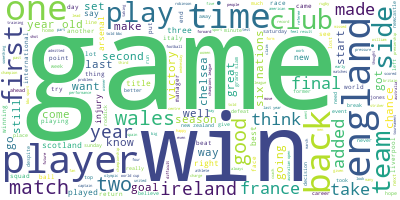

In [50]:
# exploratory data analysis using wordcloud for sport

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(resultList)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [51]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# model training
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word, num_topics = num_topics,
                                       alpha='auto', eta='auto', iterations = 20, passes = 5)
# Print the Keyword in the 10 topics
print(lda.show_topics(5))

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 3), (10, 3), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 3), (25, 2), (26, 1), (27, 2), (28, 1), (29, 1)]
[(7, '0.007*"players" + 0.005*"game" + 0.005*"back" + 0.004*"also" + 0.004*"year" + 0.004*"ferguson" + 0.004*"would" + 0.004*"great" + 0.004*"arsenal" + 0.004*"season"'), (0, '0.008*"year" + 0.007*"rugby" + 0.006*"world" + 0.005*"england" + 0.005*"time" + 0.005*"game" + 0.005*"team" + 0.005*"cup" + 0.004*"two" + 0.004*"win"'), (1, '0.009*"england" + 0.008*"ireland" + 0.006*"half" + 0.006*"first" + 0.006*"wales" + 0.006*"game" + 0.006*"side" + 0.005*"try" + 0.005*"win" + 0.005*"williams"'), (3, '0.009*"would" + 0.007*"liverpool" + 0.007*"year" + 0.006*"club" + 0.005*"one" + 0.005*"gerrard" + 0.005*"new" + 0.005*"last" + 0.005*"win" + 0.005*"best"'), (8, '0.007*"world" + 0.006*"olympic" + 0.006*"year" + 0.006*"time" + 0.005*"drugs"

In [52]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
vis_data

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.070910  0.053381       1        1  15.401612
8      0.095902  0.083139       2        1  14.380583
3      0.079705 -0.060606       3        1  11.752192
2      0.007641 -0.071349       4        1  11.191164
4      0.058663  0.031237       5        1  10.657491
9     -0.099321  0.029029       6        1  10.424414
6     -0.028915 -0.051270       7        1   9.977379
5     -0.028030 -0.012533       8        1   6.317078
0     -0.000571  0.028717       9        1   5.576331
7     -0.014163 -0.029747      10        1   4.321757, topic_info=         Term        Freq       Total Category  logprob  loglift
697   roddick  117.000000  117.000000  Default  30.0000  30.0000
772     wales  248.000000  248.000000  Default  29.0000  29.0000
735   england  417.000000  417.000000  Default  28.0000  28.0000
421    france  216.000000  216.000000  Default  27.0000  27.0000
889     rugby  186.000000  186.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1450   united    9.991629  149.214704  Topic10  -5.9793   0.4379
772     wales   10.667531  248.666317  Topic10  -5.9139  -0.0074
129     first   11.408013  449.589478  Topic10  -5.8467  -0.5325
788     coach   10.403100  209.471107  Topic10  -5.9390   0.1390
209       one   10.457179  348.808507  Topic10  -5.9338  -0.3657

[801 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
898       2  0.080173       aaas
898       3  0.801735       aaas
898       4  0.080173       aaas
1177     10  0.659667        aac
1179      2  0.039233         ac
...     ...       ...        ...
2124      7  0.095111    zealand
2124      8  0.023778    zealand
2124      9  0.023778    zealand
2124     10  0.035667    zealand
6463      3  0.676757  zvonareva

[2496 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 4, 3, 5, 10, 7, 6, 1, 8])

***For entertainment column***

In [55]:
# now the same for other topics
# LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['said', 'will', 'us']

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

""""
#Here modify the data path!!!
"""

data = df_ent.preprocessed_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])
# we need it later for word cloud
resultList = [element for nestedlist in data_words for element in nestedlist]
resultList

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marharyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['public', 'show', 'reynolds', 'portrait', 'sir', 'joshua', 'reynolds', 'portrait', 'omai', 'get', 'public', 'airing', 'following', 'fears', 'would', 'stay', 'hidden', 'export', 'wrangle', 'tate', 'gallery', 'unsuccessfully', 'tried', 'buy', 'picture', 'anonymous', 'owner', 'ban', 'issued', 'preventing']


['public',
 'show',
 'reynolds',
 'portrait',
 'sir',
 'joshua',
 'reynolds',
 'portrait',
 'omai',
 'get',
 'public',
 'airing',
 'following',
 'fears',
 'would',
 'stay',
 'hidden',
 'export',
 'wrangle',
 'tate',
 'gallery',
 'unsuccessfully',
 'tried',
 'buy',
 'picture',
 'anonymous',
 'owner',
 'ban',
 'issued',
 'preventing',
 'painting',
 'leaving',
 'uk',
 'th',
 'century',
 'painting',
 'remained',
 'storage',
 'owner',
 'agreed',
 'allow',
 'part',
 'exhibition',
 'exhibition',
 'reynolds',
 'work',
 'shown',
 'tate',
 'britain',
 'may',
 'joshua',
 'reynolds',
 'creation',
 'celebrity',
 'feature',
 'prints',
 'caricatures',
 'sculpture',
 'th',
 'century',
 'artist',
 'painted',
 'famous',
 'personalities',
 'day',
 'portrait',
 'omai',
 'fetched',
 'second',
 'highest',
 'amount',
 'british',
 'painting',
 'sold',
 'auction',
 'bought',
 'london',
 'dealer',
 'sold',
 'collector',
 'unnamed',
 'collector',
 'wanted',
 'take',
 'country',
 'barred',
 'government',
 'histor

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_s

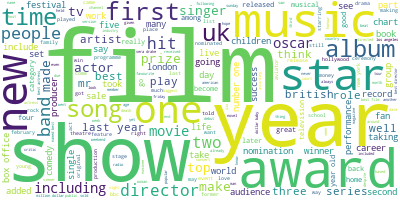

In [56]:
# exploratory data analysis using wordcloud for ent

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(resultList)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [57]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# model training
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word, num_topics = num_topics,
                                       alpha='auto', eta='auto', iterations = 20, passes = 5)
# Print the Keyword in the 10 topics
print(lda.show_topics(5))

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
[(3, '0.005*"film" + 0.005*"music" + 0.005*"mr" + 0.004*"lee" + 0.004*"new" + 0.004*"album" + 0.004*"band" + 0.004*"jackson" + 0.004*"one" + 0.004*"court"'), (7, '0.008*"year" + 0.006*"band" + 0.004*"award" + 0.004*"film" + 0.004*"best" + 0.003*"one" + 0.003*"time" + 0.003*"show" + 0.003*"mr" + 0.003*"world"'), (1, '0.029*"best" + 0.021*"film" + 0.009*"award" + 0.009*"awards" + 0.007*"actor" + 0.007*"director" + 0.007*"also" + 0.006*"actress" + 0.006*"year" + 0.005*"comedy"'), (2, '0.016*"film" + 0.006*"show" + 0.006*"new" + 0.006*"year" + 0.005*"one" + 0.005*"would" + 0.005*"also" + 0.005*"tv" + 0.004*"music" + 0.004*"first"'), (5, '0.011*"film" + 0.011*"best" + 0.008*"year" + 0.006*"song" + 0.005*"awards" + 0.005*"also" + 0.005

In [58]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
vis_data

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.047362  0.006315       1        1  19.250093
2      0.035886 -0.022733       2        1  14.034745
1      0.149710  0.020610       3        1  13.267580
6     -0.073777 -0.059800       4        1  11.287256
9     -0.014373 -0.069918       5        1   9.988766
8     -0.075179  0.084070       6        1   8.165266
4      0.045951 -0.038130       7        1   6.634135
3     -0.082463 -0.023053       8        1   6.560227
7     -0.018881  0.076023       9        1   5.628570
0     -0.014235  0.026614      10        1   5.183362, topic_info=          Term        Freq       Total Category  logprob  loglift
13        best  576.000000  576.000000  Default  30.0000  30.0000
240      album  167.000000  167.000000  Default  29.0000  29.0000
168       band  186.000000  186.000000  Default  28.0000  28.0000
208      music  376.000000  376.000000  Default  27.0000  27.0000
132     number  204.000000  204.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
13        best    8.733548  576.537474  Topic10  -6.0640  -1.2302
245      award    8.103217  220.062313  Topic10  -6.1389  -0.3419
274  including    7.793475  143.862712  Topic10  -6.1779   0.0441
94          uk    7.864335  204.522718  Topic10  -6.1688  -0.2986
208      music    7.951389  376.293219  Topic10  -6.1578  -0.8973

[782 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
6648      2  0.207460     abba
6648      6  0.103730     abba
6648      9  0.518650     abba
6648     10  0.103730     abba
0         1  0.328031  academy
...     ...       ...      ...
160       9  0.024810    years
160      10  0.029772    years
3490      3  0.279767      yen
3490      9  0.559535      yen
3490     10  0.093256      yen

[2172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 10, 9, 5, 4, 8, 1])

***For tech column***

In [60]:
# now the same for other topics
# LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['said', 'will', 'us']

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

""""
#Here modify the data path!!!
"""

data = df_tech.preprocessed_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])
# we need it later for word cloud
resultList = [element for nestedlist in data_words for element in nestedlist]
resultList

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marharyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['halo', 'sells', 'five', 'million', 'copies', 'microsoft', 'celebrating', 'bumper', 'sales', 'xbox', 'sci', 'fi', 'shooter', 'halo', 'game', 'sold', 'five', 'million', 'copies', 'worldwide', 'since', 'went', 'sale', 'mid', 'november', 'company', 'halo', 'proved', 'popular', 'online']


['halo',
 'sells',
 'five',
 'million',
 'copies',
 'microsoft',
 'celebrating',
 'bumper',
 'sales',
 'xbox',
 'sci',
 'fi',
 'shooter',
 'halo',
 'game',
 'sold',
 'five',
 'million',
 'copies',
 'worldwide',
 'since',
 'went',
 'sale',
 'mid',
 'november',
 'company',
 'halo',
 'proved',
 'popular',
 'online',
 'gamers',
 'notching',
 'record',
 'million',
 'hours',
 'playing',
 'game',
 'xbox',
 'live',
 'according',
 'microsoft',
 'nine',
 'xbox',
 'live',
 'members',
 'played',
 'game',
 'average',
 'minutes',
 'per',
 'session',
 'sequel',
 'best',
 'selling',
 'need',
 'speed',
 'underground',
 'inched',
 'ahead',
 'competition',
 'take',
 'top',
 'slot',
 'official',
 'uk',
 'games',
 'charts',
 'racing',
 'game',
 'moved',
 'one',
 'spot',
 'first',
 'place',
 'nudging',
 'gta',
 'san',
 'andreas',
 'second',
 'place',
 'halo',
 'dropped',
 'one',
 'place',
 'five',
 'half',
 'life',
 'fell',
 'number',
 'nine',
 'last',
 'week',
 'new',
 'releases',
 'goldeneye',
 'rogue',
 

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_s

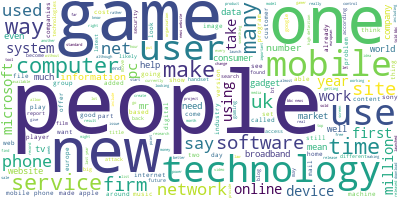

In [61]:
# exploratory data analysis using wordcloud for ent

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(resultList)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [62]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# model training
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word, num_topics = num_topics,
                                       alpha='auto', eta='auto', iterations = 20, passes = 5)
# Print the Keyword in the 10 topics
print(lda.show_topics(5))

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1)]
[(0, '0.014*"game" + 0.005*"time" + 0.004*"apple" + 0.004*"also" + 0.004*"world" + 0.004*"halo" + 0.004*"like" + 0.003*"one" + 0.003*"top" + 0.003*"people"'), (3, '0.006*"people" + 0.006*"one" + 0.005*"technology" + 0.005*"world" + 0.005*"software" + 0.004*"could" + 0.004*"computer" + 0.004*"new" + 0.003*"would" + 0.003*"also"'), (4, '0.012*"people" + 0.008*"phone" + 0.007*"mobile" + 0.007*"online" + 0.006*"net" + 0.005*"uk" + 0.005*"broadband" + 0.005*"many" + 0.005*"mr" + 0.005*"new"'), (7, '0.007*"software" + 0.007*"mobile" + 0.006*"security" + 0.005*"also" + 0.005*"new" + 0.005*"users" + 0.005*"one" + 0.005*"microsoft" + 0.005*"programs" + 0.004*"networks"'), (5, '0.013*"people" + 0.008*"tv" + 0.008*"digital" + 0.006*"search"

In [63]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
vis_data

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.019183 -0.096373       1        1  15.232744
5     -0.046992  0.030831       2        1  14.797490
4     -0.043938  0.053956       3        1  10.541479
6     -0.010712 -0.053363       4        1  10.524764
9      0.032805  0.023332       5        1  10.315542
2      0.014989 -0.002184       6        1   9.584229
8     -0.022592 -0.037732       7        1   9.220492
1     -0.087007  0.058484       8        1   8.675091
3      0.051658 -0.023752       9        1   7.179749
0      0.130972  0.046800      10        1   3.928420, topic_info=           Term        Freq       Total Category  logprob  loglift
39         game  282.000000  282.000000  Default  30.0000  30.0000
1935  broadband  225.000000  225.000000  Default  29.0000  29.0000
721          bt  113.000000  113.000000  Default  28.0000  28.0000
490      mobile  458.000000  458.000000  Default  27.0000  27.0000
649       phone  290.000000  290.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
89       online    9.637311  278.301273  Topic10  -6.1270  -0.1261
143        xbox    8.388673   73.838926  Topic10  -6.2657   1.0619
551        used    9.349330  257.348474  Topic10  -6.1573  -0.0782
2460  consumers    8.522425  123.366476  Topic10  -6.2499   0.5645
65         make    8.763634  296.728191  Topic10  -6.2220  -0.2853

[807 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
699       1  0.196359  access
699       2  0.196359  access
699       3  0.215362  access
699       4  0.038005  access
699       5  0.095013  access
...     ...       ...     ...
981       9  0.046821   years
981      10  0.033444   years
7896      7  0.866011   yoran
7896      9  0.123716   yoran
8647      8  0.845378    zafi

[2475 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 5, 7, 10, 3, 9, 2, 4, 1])

***For politics column***

In [64]:
# now the same for other topics
# LDA analysis
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + ['said', 'will', 'us']

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

""""
#Here modify the data path!!!
"""

data = df_politics.preprocessed_text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])
# we need it later for word cloud
resultList = [element for nestedlist in data_words for element in nestedlist]
resultList

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marharyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['msps', 'hear', 'renewed', 'climate', 'warning', 'climate', 'change', 'could', 'completely', 'control', 'within', 'several', 'decades', 'scottish', 'environment', 'protection', 'agency', 'warning', 'committee', 'msps', 'experts', 'giving', 'evidence', 'subject', 'scottish', 'parliament', 'environment', 'committee', 'officials', 'believe']


['msps',
 'hear',
 'renewed',
 'climate',
 'warning',
 'climate',
 'change',
 'could',
 'completely',
 'control',
 'within',
 'several',
 'decades',
 'scottish',
 'environment',
 'protection',
 'agency',
 'warning',
 'committee',
 'msps',
 'experts',
 'giving',
 'evidence',
 'subject',
 'scottish',
 'parliament',
 'environment',
 'committee',
 'officials',
 'believe',
 'nuclear',
 'energy',
 'wind',
 'farms',
 'may',
 'better',
 'options',
 'trying',
 'tackle',
 'global',
 'warming',
 'solutions',
 'suggested',
 'include',
 'reducing',
 'internal',
 'uk',
 'air',
 'travel',
 'boosting',
 'electric',
 'trains',
 'evidence',
 'part',
 'committee',
 'inquiry',
 'impact',
 'climate',
 'change',
 'scotland',
 'sepa',
 'attempting',
 'curb',
 'global',
 'warming',
 'gases',
 'pollution',
 'transport',
 'emissions',
 'increases',
 'ecologists',
 'warning',
 'msps',
 'scotland',
 'may',
 'accept',
 'significant',
 'intrusion',
 'wind',
 'farms',
 'likely',
 'also',
 'nuclear',
 'power',
 'need

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/marharyta/Desktop/Data_science/IT_Academy/Data_s

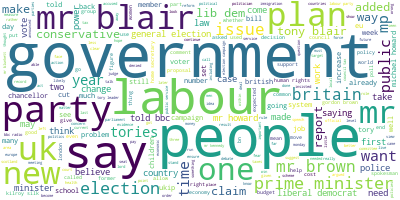

In [65]:
# exploratory data analysis using wordcloud for ent

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(resultList)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [66]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

# model training
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word, num_topics = num_topics,
                                       alpha='auto', eta='auto', iterations = 20, passes = 5)
# Print the Keyword in the 10 topics
print(lda.show_topics(5))

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 4), (19, 2), (20, 3), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1)]
[(8, '0.009*"mr" + 0.008*"labour" + 0.006*"government" + 0.005*"new" + 0.005*"would" + 0.004*"people" + 0.004*"blair" + 0.004*"one" + 0.004*"party" + 0.003*"also"'), (1, '0.011*"mr" + 0.007*"would" + 0.006*"asylum" + 0.006*"people" + 0.005*"children" + 0.005*"could" + 0.004*"government" + 0.004*"uk" + 0.004*"bill" + 0.003*"system"'), (2, '0.024*"mr" + 0.011*"blair" + 0.008*"labour" + 0.008*"would" + 0.008*"minister" + 0.007*"brown" + 0.006*"prime" + 0.006*"government" + 0.006*"election" + 0.006*"told"'), (5, '0.016*"mr" + 0.010*"would" + 0.007*"party" + 0.006*"blair" + 0.006*"also" + 0.005*"people" + 0.005*"government" + 0.005*"new" + 0.004*"public" + 0.004*"labour"'), (3, '0.018*"mr" + 0.012*"would" + 0.009*"labour" + 0.009*"gov

In [67]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, id2word)
vis_data

/Users/marharyta/Desktop/Data_science/IT_Academy/Data_science_course/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.047118 -0.047480       1        1  22.539728
2      0.049943 -0.004456       2        1  13.304289
5      0.008361 -0.023416       3        1  12.688450
9     -0.067950 -0.014001       4        1  10.086592
7      0.076548 -0.045732       5        1   9.793317
6      0.003130  0.075495       6        1   9.042146
0     -0.109138 -0.055125       7        1   7.059525
1     -0.020445  0.071226       8        1   5.472126
4      0.034609  0.024177       9        1   5.065864
8     -0.022177  0.019312      10        1   4.947964, topic_info=          Term        Freq       Total Category  logprob  loglift
2099      ukip  116.000000  116.000000  Default  30.0000  30.0000
184   election  560.000000  560.000000  Default  29.0000  29.0000
5140    kilroy  109.000000  109.000000  Default  28.0000  28.0000
5156      silk   99.000000   99.000000  Default  27.0000  27.0000
216     labour  705.000000  705.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
680       year   11.754332  257.270242  Topic10  -6.0729  -0.0797
24       could   11.920547  349.202450  Topic10  -6.0588  -0.3712
208     howard   11.277845  294.968321  Topic10  -6.1143  -0.2578
59        last   10.746986  185.410278  Topic10  -6.1625   0.1582
303       tory   10.717926  249.803971  Topic10  -6.1652  -0.1426

[791 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9664      6  0.848780  abortion
2841      1  0.122316    access
2841      2  0.513725    access
2841      3  0.024463    access
2841      4  0.097852    access
...     ...       ...       ...
1868      1  0.073103   younger
1868      2  0.073103   younger
1868      3  0.146205   younger
1868      5  0.584820   younger
1868      6  0.073103   younger

[2484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 10, 8, 7, 1, 2, 5, 9])